In [2]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
from scipy.signal import savgol_filter
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
import os
import numpy as np
import warnings

# plt.rcParams['figure.figsize'] = [10, 10]

# Preprocessing - Refine camera parameters

## Initial camera parameters filtering

In [3]:
camParamsPath = "Labels-GameState360.json"
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()

### Interpolation of neighboring complete parameters to replace non complete parameters with an aproximation

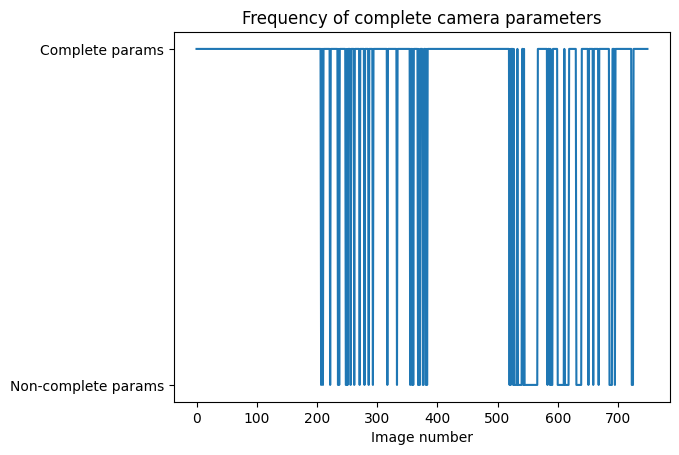

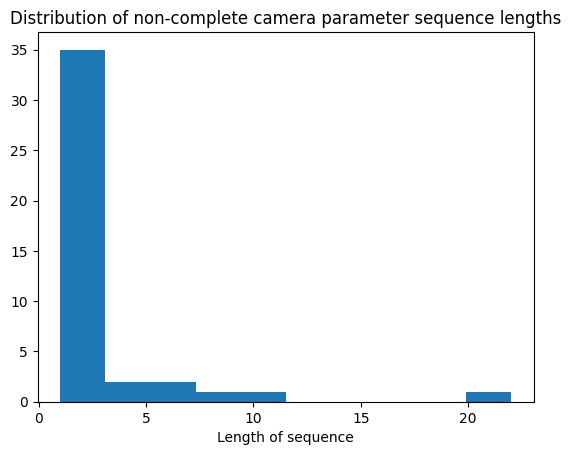

In [4]:
completeParams = np.zeros(len(camParams), dtype=np.bool_)
distOfNonCompleteParams = []
currDist = 0
for i, params in enumerate(camParams):
	if type(params) is dict:
		completeParams[i] = True
		if currDist > 0:
			distOfNonCompleteParams.append(currDist)
			currDist = 0
	else:
		completeParams[i] = False
		currDist += 1

plt.plot(completeParams)
plt.title("Frequency of complete camera parameters")
# Change y axis to show "complete params" and "non-complete params" instead of 0 and 1
plt.yticks([0, 1], ["Non-complete params", "Complete params"])
plt.xlabel("Image number")
plt.show()
plt.hist(distOfNonCompleteParams)
plt.title("Distribution of non-complete camera parameter sequence lengths")
plt.xlabel("Length of sequence")
plt.show()

In [5]:
# Will be used later
for param in camParams:
	if type(param) == dict:
		tmpCompleteParam = param
		break
isNonCompleteParams = np.array([type(x) != dict for x in camParams])
posNonCompleteParams = np.where(isNonCompleteParams)[0]

Apply the basic solution to replace non complete camera parameters with a complete parameter. For example the non complete parameter can be the homography matrix, which do not contain all the camera parameters. In that case the missing parameters can be aproximated by using the previous camera parameters.

In [6]:
if type(camParams[0]) == type(None):
	idx = 1
	while type(camParams[idx]) != dict:
		idx += 1
	camParams[0] = camParams[idx]
if type(camParams[0]) == list:
	idx = 1
	while type(camParams[idx]) != dict:
		idx += 1
	cam.from_json_parameters(camParams[idx])
	cam.from_homography(camParams[0])
	camParams[0] = cam.to_json_parameters()
for i in range(1, len(camParams)):
	if type(camParams[i]) == type(None):
		camParams[i] = camParams[i - 1]
	elif type(camParams[i]) == list:
		cam.from_json_parameters(camParams[i - 1])  # the homography won't give info about some camera parameters such as the distortions, so we take the previous camera parameters as a starting point
		cam.from_homography(camParams[i])
		camParams[i] = cam.to_json_parameters()

In [7]:
indCamParams = {
	"pan_degrees": [x["pan_degrees"] for x in camParams],
	"tilt_degrees": [x["tilt_degrees"] for x in camParams],
	"roll_degrees": [x["roll_degrees"] for x in camParams],
	"position_meters": [x["position_meters"] for x in camParams],
	"x_focal_length": [x["x_focal_length"] for x in camParams],
	"y_focal_length": [x["y_focal_length"] for x in camParams],
	"principal_point": [x["principal_point"] for x in camParams],
	"radial_distortion": [x["radial_distortion"] for x in camParams],
	"tangential_distortion": [x["tangential_distortion"] for x in camParams],
	"thin_prism_distortion": [x["thin_prism_distortion"] for x in camParams]
}
for key in indCamParams:
	indCamParams[key] = np.array(indCamParams[key])
indCamParamsOrig = deepcopy(indCamParams)

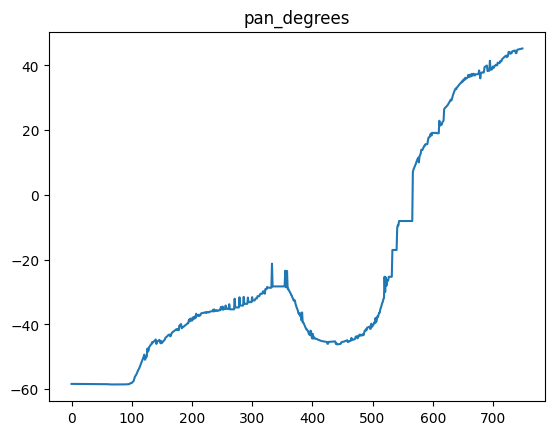

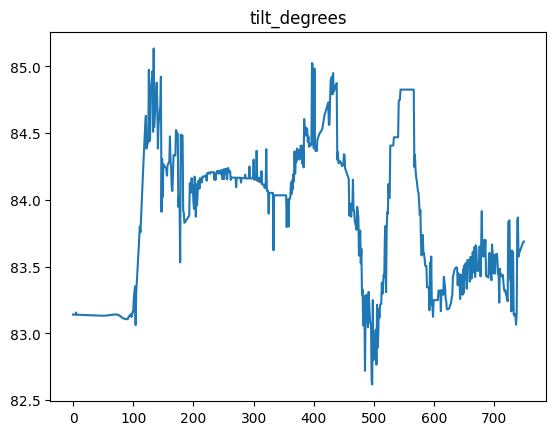

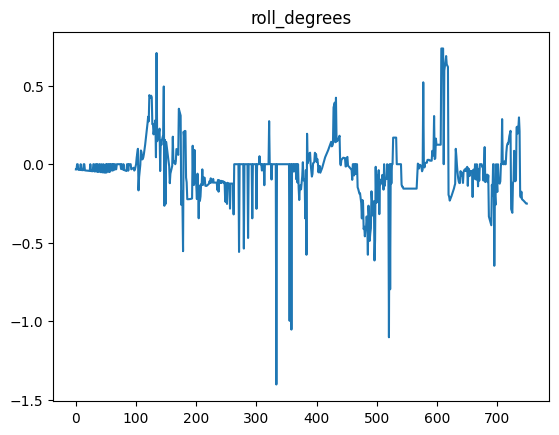

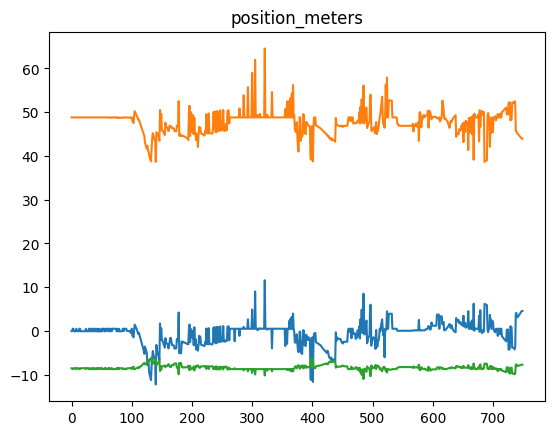

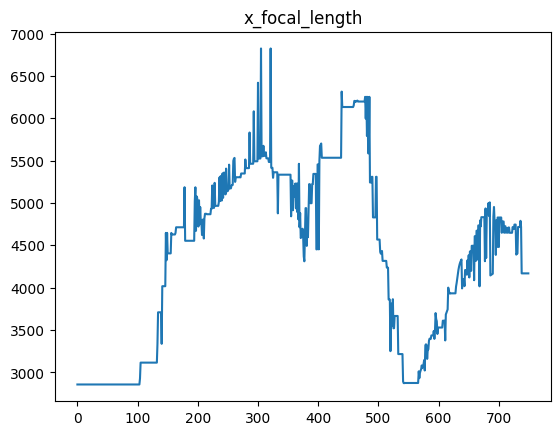

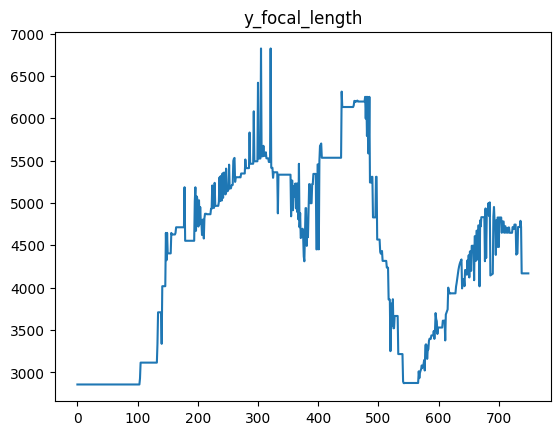

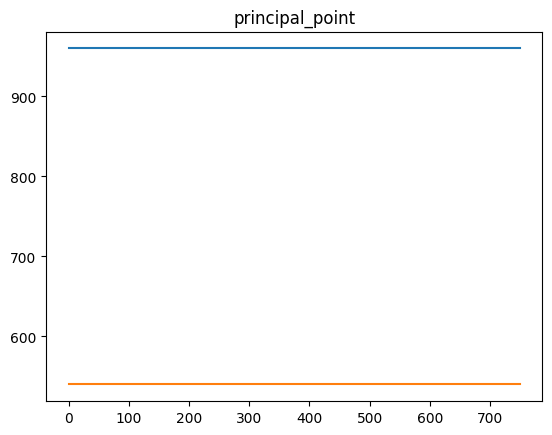

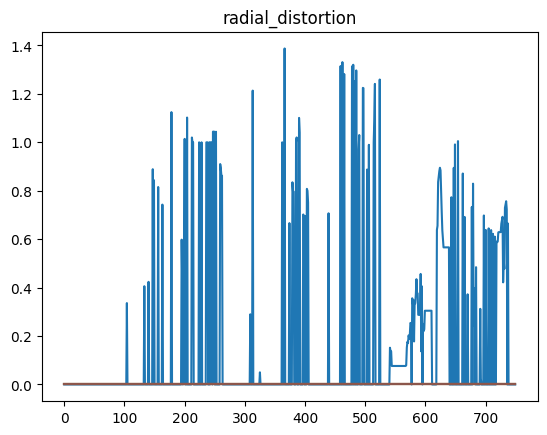

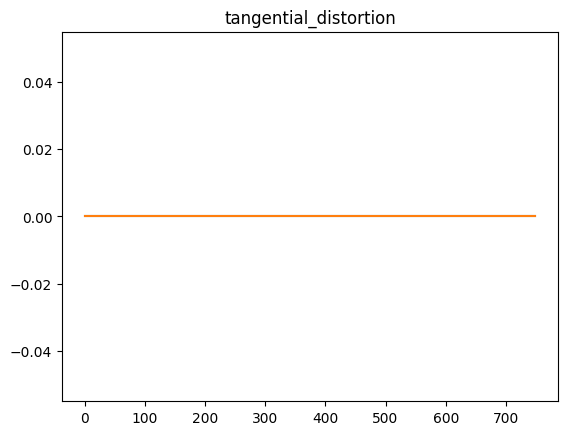

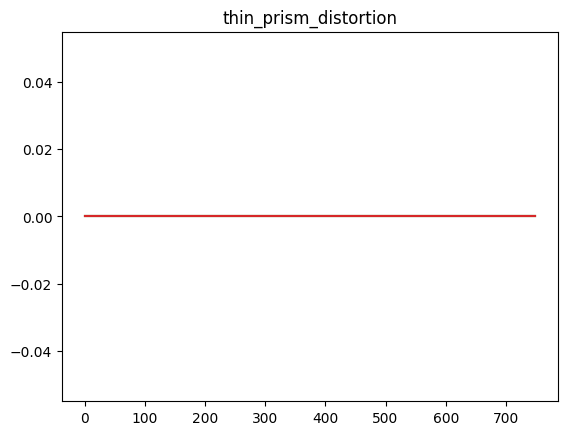

In [8]:
# plot each key in indCamParams in a subplot
for key in indCamParams.keys():
	plt.plot(indCamParams[key])
	plt.title(key)
	plt.show()

Linear interpolation of non complete camera parameters

In [9]:
xp = []  # positions of complete camera parameters next to non-complete camera parameters
if not isNonCompleteParams[0] and isNonCompleteParams[1]:
	xp.append(0)
if not isNonCompleteParams[-1] and isNonCompleteParams[-2]:
	xp.append(len(camParams) - 1)
for i in range(1, len(camParams) - 1):
	if not isNonCompleteParams[i] and (isNonCompleteParams[i - 1] or isNonCompleteParams[i + 1]):
		xp.append(i)
# Replace non-complete camera parameters with a temporary complete camera parameter to be able to modify 'pan_degrees', 'tilt_degrees', 'roll_degrees', 'position_meters', ...
for pos in posNonCompleteParams:
	camParams[pos] = tmpCompleteParam

In [10]:
for key, value in indCamParams.items():
	if len(value.shape) == 1:
		indCamParams[key][posNonCompleteParams] = np.interp(posNonCompleteParams, xp, value[xp])
	else: # 2D array
		for i in range(value.shape[1]):
			indCamParams[key][posNonCompleteParams, i] = np.interp(posNonCompleteParams, xp, value[xp, i])

(108,) (108,)


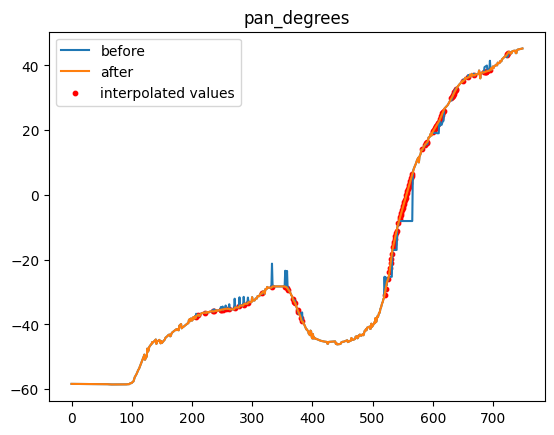

(108,) (108,)


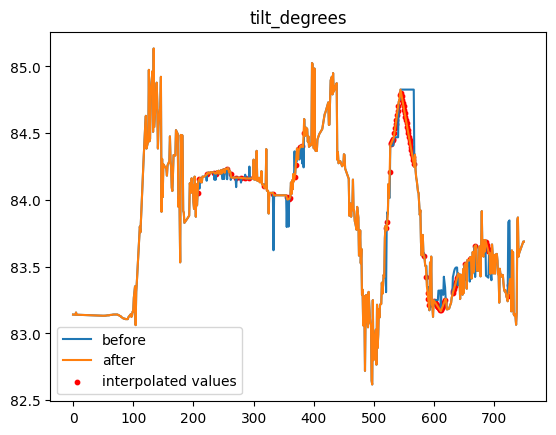

(108,) (108,)


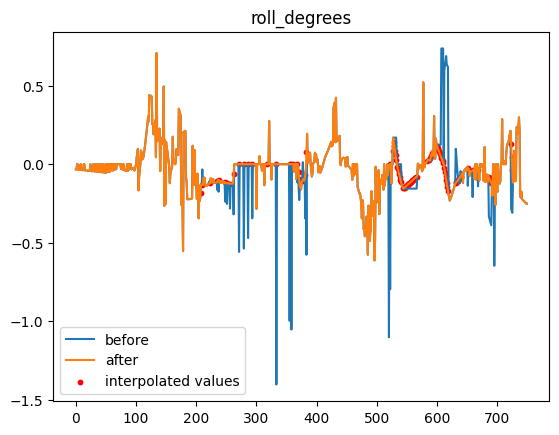

(108,) (108, 3)


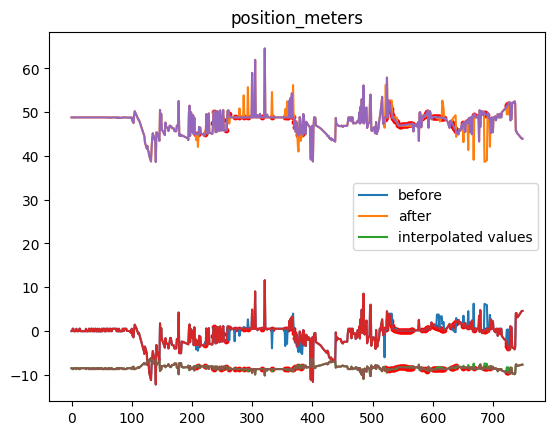

(108,) (108,)


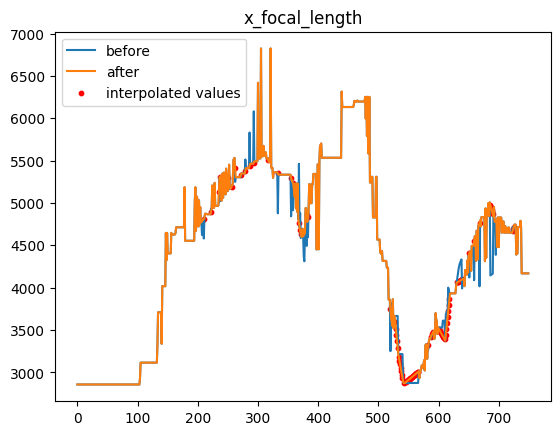

(108,) (108,)


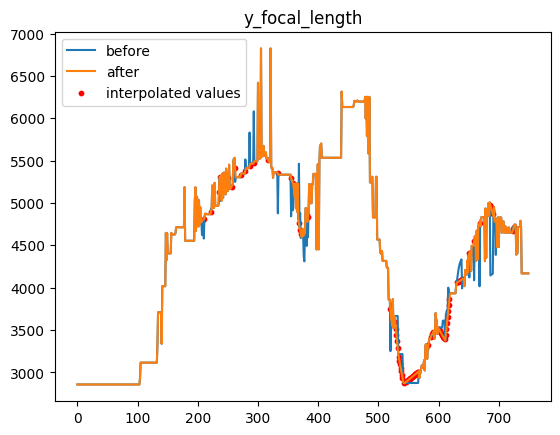

(108,) (108, 2)


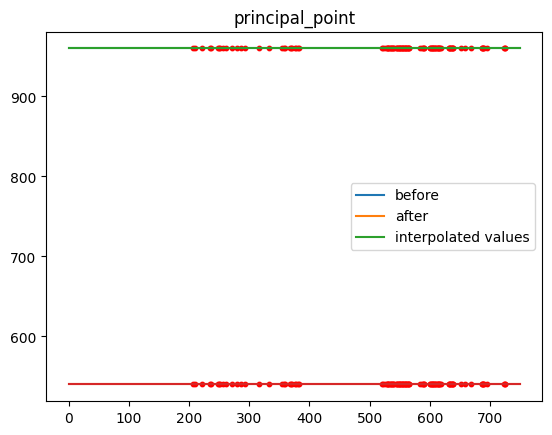

(108,) (108, 6)


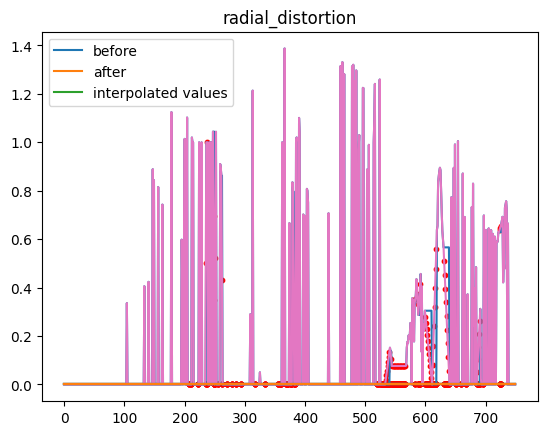

(108,) (108, 2)


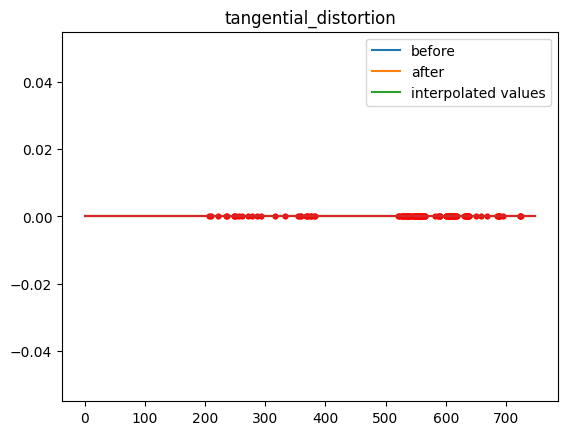

(108,) (108, 4)


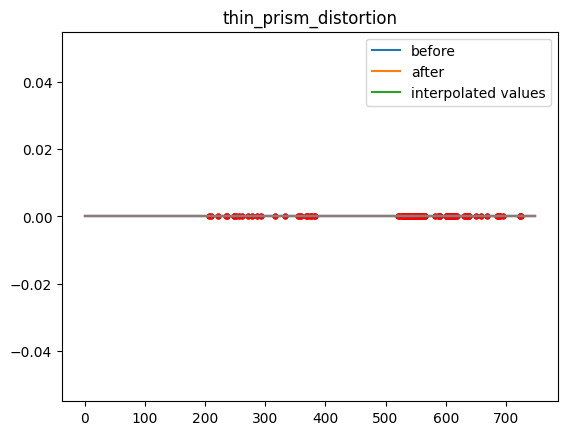

In [11]:
# Compare the original and the modified camera parameters
for key in indCamParams.keys():
	# plt.figure(figsize=(15, 15))
	plt.plot(indCamParamsOrig[key])
	plt.plot(indCamParams[key])
	# plt points x=posNonCompleteParams, y=indCamParams[key][posNonCompleteParams]
	print(posNonCompleteParams.shape, indCamParams[key][posNonCompleteParams].shape)
	if len(indCamParams[key][posNonCompleteParams].shape) == 1:
		plt.scatter(posNonCompleteParams, indCamParams[key][posNonCompleteParams], color='red', s=10)
	else:
		for i in range(indCamParams[key][posNonCompleteParams].shape[1]):
			plt.scatter(posNonCompleteParams, indCamParams[key][posNonCompleteParams, i], color='red', s=10)
	plt.title(key)
	plt.legend(["before", "after", "interpolated values"])
	plt.show()

### Smoothing of the camera parameters using savgol filter

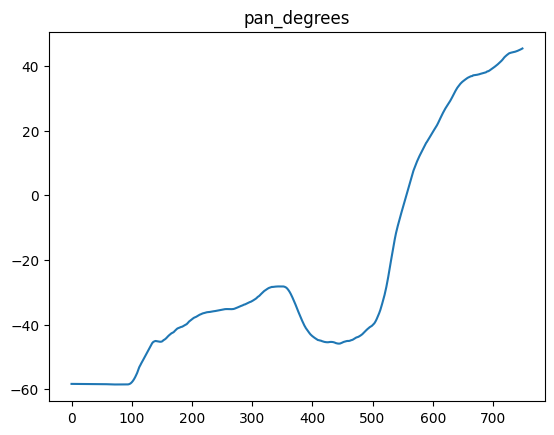

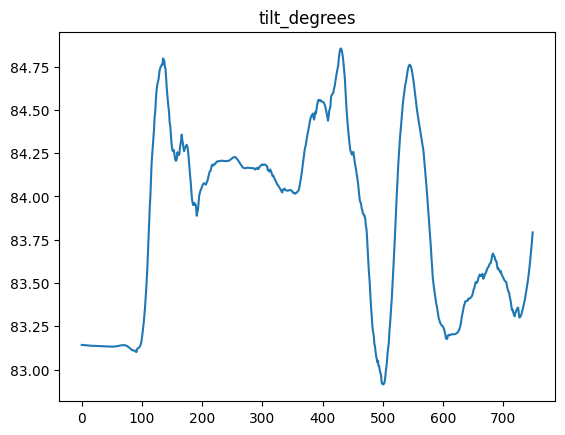

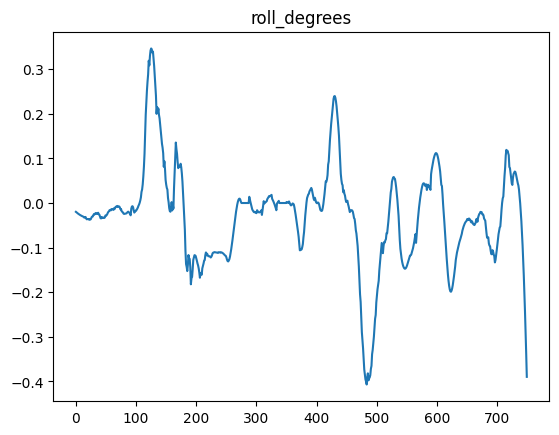

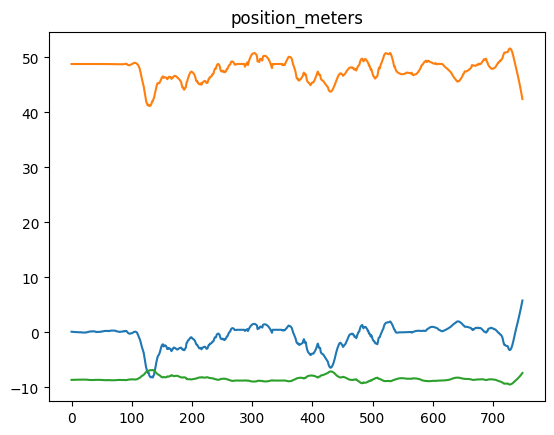

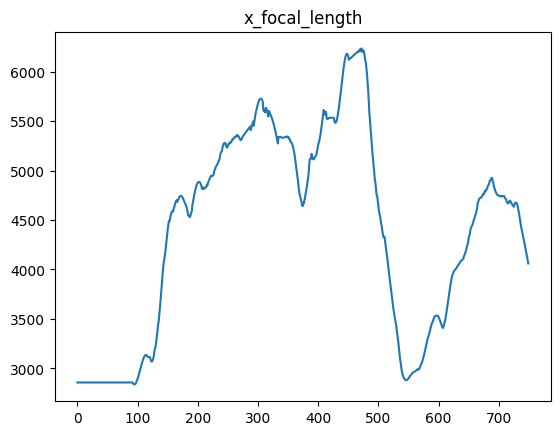

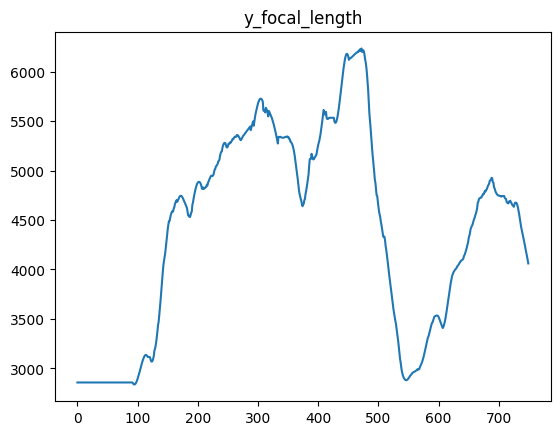

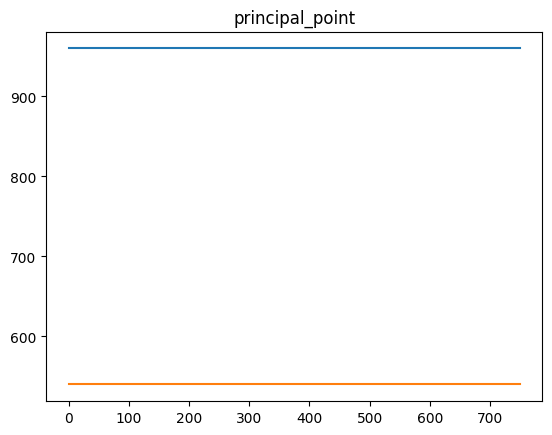

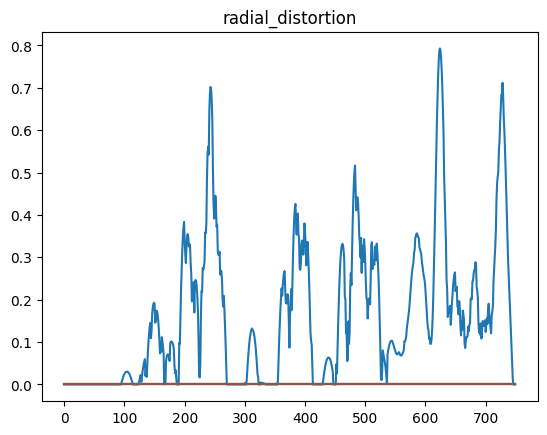

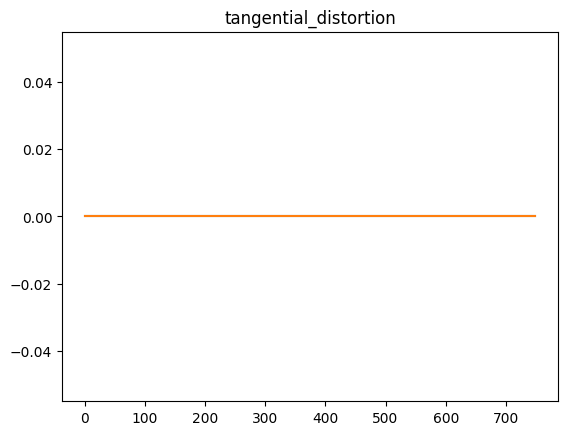

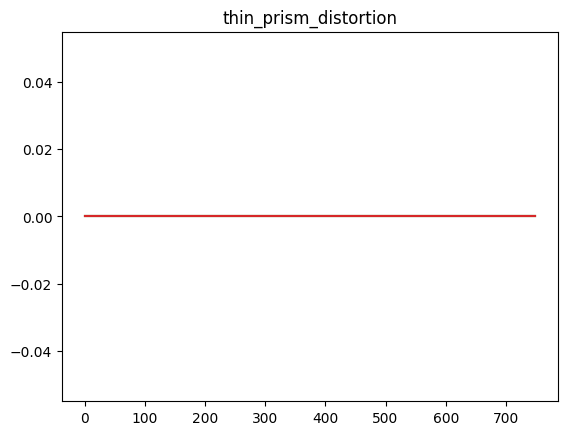

In [12]:
smoothedIndCamParams = deepcopy(indCamParams)
for key in indCamParams.keys():
	smoothedIndCamParams[key] = savgol_filter(indCamParams[key], 25, 2, axis=0)
# clamp values of radial_distortion, tangential_distortion and thin_prism_distortion btw 0 and +inf
for key in ["radial_distortion", "tangential_distortion", "thin_prism_distortion"]:
	smoothedIndCamParams[key] = np.maximum(smoothedIndCamParams[key], 0)
for key in smoothedIndCamParams.keys():
	plt.plot(smoothedIndCamParams[key])
	plt.title(key)
	plt.show()

In [13]:
smoothedCamParams = [dict(zip(smoothedIndCamParams.keys(), [smoothedIndCamParams[key][i] for key in smoothedIndCamParams.keys()])) for i in range(len(camParams))]

## Semantic segmentation masks filtering

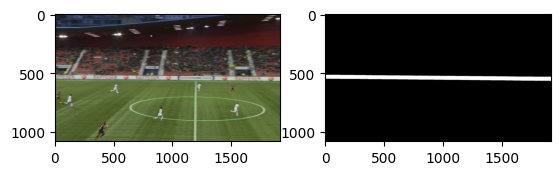

In [14]:
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 550

img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
cam.from_json_parameters(smoothedCamParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
imgWithLines = deepcopy(img)
imgWithLines = cam.draw_pitch(cam.draw_corners(imgWithLines))
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imgWithLines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

### Keep biggest blob in the mask

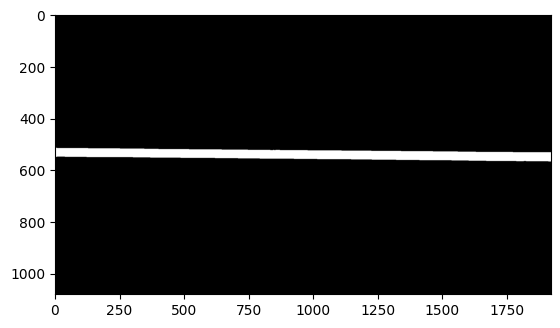

In [15]:
# plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')

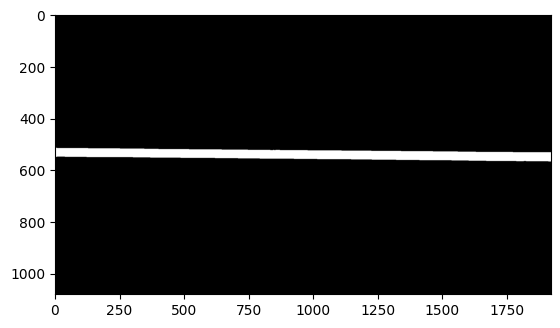

In [16]:
# find the blob with the largest area. Another option might be to find the blob with the largest perimeter. The second solution is below in the commented code
# contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# largest_contour = max(contours, key=len)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
biggestBloBMask = np.zeros(mask.shape, np.uint8)
cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
mask = biggestBloBMask
plt.imshow(mask, cmap='gray')

### Compute corner position

Euristic: There is always at most one corner in the image and it is located at the topest point in the non-zero pixels of the mask.
!!! Only for the top left and right corners !!!

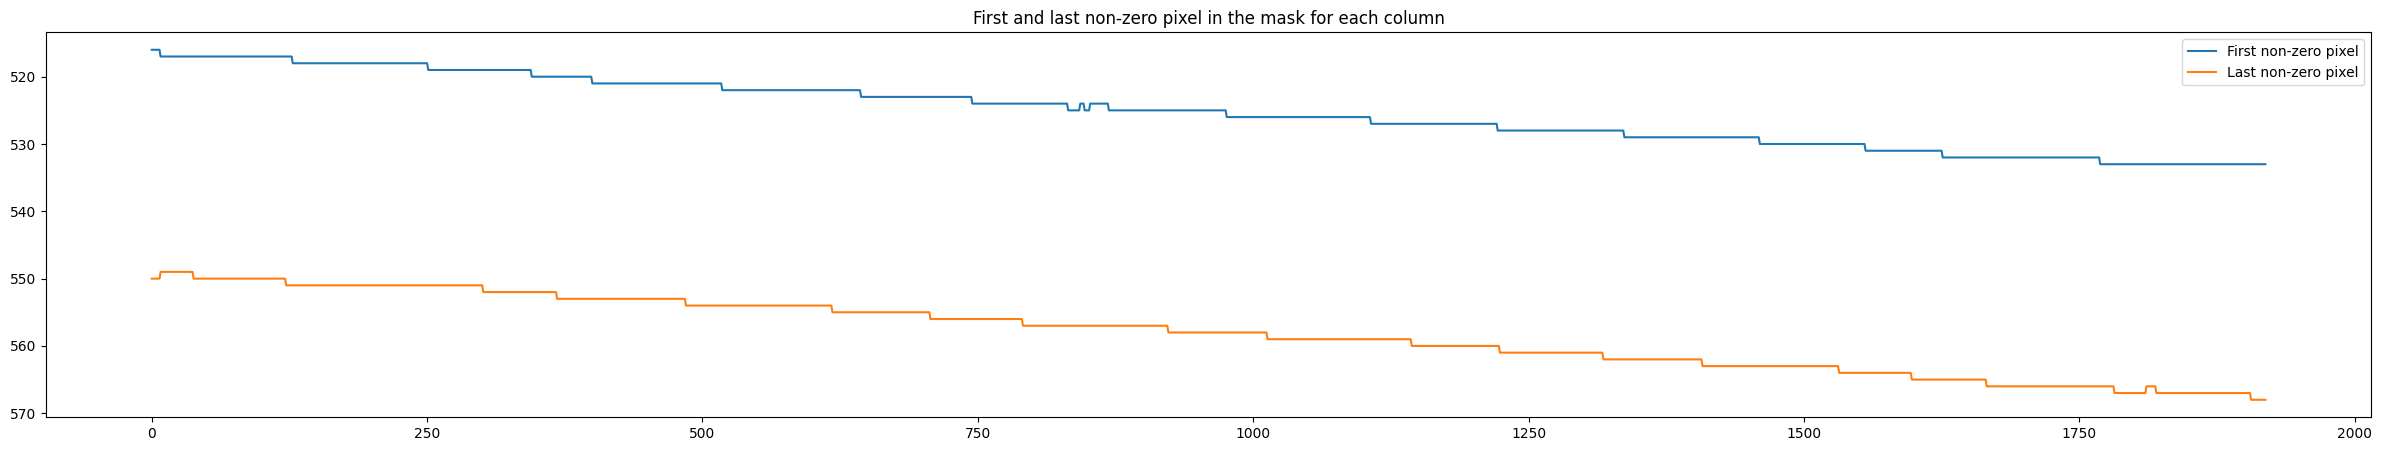

In [17]:
binMask = np.uint8(mask > 0)
firstNonZeroIdx = np.argmax(binMask, axis=0)
colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
flipped = cv2.flip(binMask, 0)
flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
# colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1

plt.figure(figsize=(30, 5))
# flip y axis
plt.gca().invert_yaxis()
plt.plot(colsWithNonZero, firstNonZeroIdx)
plt.plot(colsWithNonZero, lastNonZeroIdx)
plt.title("First and last non-zero pixel in the mask for each column")
plt.legend(["First non-zero pixel", "Last non-zero pixel"])
plt.show()

In [18]:
colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]

array([0, 1, 2, 3, 4, 5, 6, 7])

In [19]:
colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int)

4

In [20]:
tmp = np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)
print(tmp)
print(lastNonZeroIdx[tmp])
pixel = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int), lastNonZeroIdx[tmp]])
pixel

4
550


array([  4, 550])

In [21]:
cam.unproject_point_on_planeZ0(pixel)[:2]

array([-35.2151233 , -36.34659989])

In [22]:
np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])

array([  4, 550])

In [23]:
cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(pixel)[:2]
cornerCoordX, cornerCoordY

(-35.21512329927896, -36.346599885703064)

In [24]:
cornerCol = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean().round().astype(int)
cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(pixel)[:2]
print(cornerCoordX, cornerCoordY)
print(cornerCoordY < -68/2, cornerCoordX < -105/2, cornerCoordX > 105/2)
if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
	plt.figure(figsize=(30, 5))
	plt.gca().invert_yaxis()
	plt.plot(colsWithNonZero, firstNonZeroIdx)
	plt.scatter(cornerCol, np.min(firstNonZeroIdx), color='red')
	plt.title("First non-zero pixel in the mask for each column")
	plt.legend(["First non-zero pixel", "Corner"])
	plt.show()
print('cornerCol:', cornerCol)

-35.21512329927896 -36.346599885703064
True False False
cornerCol: 4


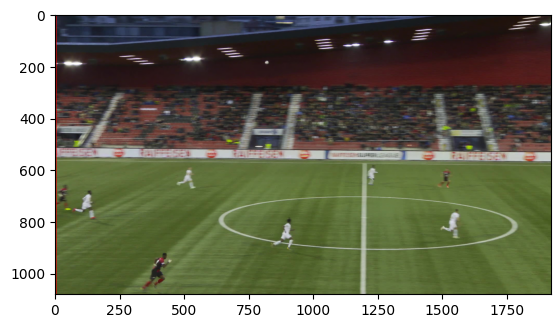

In [25]:
# draw a vertical line at the corner column on the image
imgWithCornerLine = deepcopy(img)
if cornerCol != -1:
	cv2.line(imgWithCornerLine, (cornerCol, 0), (cornerCol, img.shape[0]), (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(imgWithCornerLine, cv2.COLOR_BGR2RGB))

In [53]:
cornerCoordXs = []
cornerCoordYs = []

for i in tqdm(range(750)):
	img = cv2.imread(imgPath + str(i+1).zfill(6) + '.jpg')
	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
	cam.from_json_parameters(smoothedCamParams[i])
	binMask = np.uint8(mask > 0)
	contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	largest_contour = max(contours, key=cv2.contourArea)
	biggestBloBMask = np.zeros(mask.shape, np.uint8)
	cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
	mask = biggestBloBMask
	binMask = np.uint8(mask > 0)
	firstNonZeroIdx = np.argmax(binMask, axis=0)
	colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
	flipped = cv2.flip(binMask, 0)
	flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
	colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
	firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
	flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
	lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
	cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
	cornerCol = cornerCols.mean().round().astype(int)
	point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
	cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
	if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
		cornerCoordXs.append(cornerCoordX)
		cornerCoordYs.append(cornerCoordY)
# 		# cv2.line(img, (cornerCol, 0), (cornerCol, img.shape[0]), (0, 0, 255), 2)
# 		cv2.circle(img, tuple(point2D.astype(int)), 5, (0, 0, 255), -1)
# 	# write the img number on the image
# 	cv2.putText(img, str(i+1), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
# 	cv2.imshow('image', img)
# 	cv2.waitKey(20)

# cv2.destroyAllWindows()

100%|██████████| 750/750 [00:31<00:00, 23.60it/s]


In [27]:
cornerCoordXs = np.array(cornerCoordXs)
cornerCoordYs = np.array(cornerCoordYs)
print(cornerCoordXs[cornerCoordXs < 0].mean(), cornerCoordYs[cornerCoordXs < 0].mean())
print(cornerCoordXs[cornerCoordXs < 0].std(), cornerCoordYs[cornerCoordXs < 0].std())
print(cornerCoordXs[cornerCoordXs > 0].mean(), cornerCoordYs[cornerCoordXs > 0].mean())
print(cornerCoordXs[cornerCoordXs > 0].std(), cornerCoordYs[cornerCoordXs > 0].std())

-56.926983162556944 -39.02397677872232
0.5575190434783731 0.8651864482417612
56.894341513165855 -38.31300349528329
0.3515351649082167 0.5688963751174868


In [28]:
cornersCoords = dict()
cornersCoords['left'] = dict()
cornersCoords['right'] = dict()
cornersCoords['left']['x'] = cornerCoordXs[cornerCoordXs < 0].mean()
cornersCoords['left']['y'] = cornerCoordYs[cornerCoordXs < 0].mean()
cornersCoords['right']['x'] = cornerCoordXs[cornerCoordXs > 0].mean()
cornersCoords['right']['y'] = cornerCoordYs[cornerCoordXs > 0].mean()

In [29]:
# for i in tqdm(range(600, 750)):
# 	img = cv2.imread(imgPath + str(i+1).zfill(6) + '.jpg')
# 	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# 	cam.from_json_parameters(smoothedCamParams[i])
# 	binMask = np.uint8(mask > 0)
# 	contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 	largest_contour = max(contours, key=cv2.contourArea)
# 	biggestBloBMask = np.zeros(mask.shape, np.uint8)
# 	cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
# 	mask = biggestBloBMask
# 	binMask = np.uint8(mask > 0)
# 	firstNonZeroIdx = np.argmax(binMask, axis=0)
# 	colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
# 	flipped = cv2.flip(binMask, 0)
# 	flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
# 	colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
# 	firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
# 	flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
# 	lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
# 	cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
# 	cornerCol = cornerCols.mean().round().astype(int)
# 	point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
# 	cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
# 	if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
# 		cv2.line(img, (cornerCol, 0), (cornerCol, img.shape[0]), (0, 0, 255), 2)
# 	for side in ['left', 'right']:
# 		modelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], cornersCoords[side]['y'], 0]))[0].round().astype(int)
# 		modelCornerCol = np.clip(modelCornerCol, 0, img.shape[1] - 1)
# 		if modelCornerCol != 0 and modelCornerCol != img.shape[1] - 1:
# 			cv2.line(img, (modelCornerCol, 0), (modelCornerCol, img.shape[0]), (0, 255, 0), 2)
# 	cam.draw_pitch(cam.draw_corners(img))
# 	# write the img number on the image
# 	cv2.putText(img, str(i+1), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
# 	cv2.imshow('image', img)
# 	cv2.waitKey(40)

# cv2.destroyAllWindows()

Taking into account distorsions to compute the banner model parameters seems to reduce the error in the final result. (std is reduced and std of the error is thus reduced)

To compute the banner distance to the pitch field edge, the mean of the mean of each image is computed instead of the mean of every image column of all images. This seems to reduce (a bit) the std (error). However the height is still computed using the mean of the columns.
! Need to check usign other videos what is the best way to the banner model parameters !

2 solutions to compte the banner model dist parameters:
- Using only the points in the "soccer field dimensions", thus not the points close to the banner corners since they are not 100% reliable.
- Using all the points in the image.

Need to check which one is the best. It seems that in terms of std the first solution is better. But the banner corner position is still quite reliable so why not use it ?

In [30]:
heights = np.zeros(750 * 1920, dtype=np.float64)
heightsArrayLen = 0

bannersDims = dict()
sides = ['left', 'middle', 'right']
for side in sides:
	bannersDims[side] = dict()
	bannersDims[side]['distArray'] = np.zeros(750, dtype=np.float64)
	bannersDims[side]['distArray'][:] = np.nan
	
# stats = dict()
# for side in sides:
# 	stats[side] = dict()
# 	stats[side]['mean'] = np.zeros(750, dtype=np.float64)
# 	stats[side]['mean'][:] = np.nan
# 	stats[side]['std'] = np.zeros(750, dtype=np.float64)
# 	stats[side]['std'][:] = np.nan

# for i in tqdm(range(749,750)):
for i in tqdm(range(750)):
	cam.from_json_parameters(smoothedCamParams[i])
	img = cv2.imread(imgPath + str(i+1).zfill(6) + '.jpg')
	mask = cv2.imread(maskPath + str(i+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
	binMask = np.uint8(mask > 0)
	contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	largest_contour = max(contours, key=cv2.contourArea)
	biggestBloBMask = np.zeros(mask.shape, np.uint8)
	cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
	mask = biggestBloBMask
	binMask = np.uint8(mask > 0)
	firstNonZeroIdx = np.argmax(binMask, axis=0)
	colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
	flipped = cv2.flip(binMask, 0)
	flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
	colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
	# colsWithNonZero is the set of columns that have at least one non-zero pixel in the mask and the non-zero pixels are not at the top or bottom of the image
	firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
	flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
	lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
	points2D = np.array([[x, y] for x, y in zip(colsWithNonZero, lastNonZeroIdx)])
	unprojectedPoints = np.array([cam.unproject_point_on_planeZ0(p, undistort=True) for p in points2D])
	unprojectedPoints[:, 2] = -1
	z1m = [cam.project_point(p, distort=True)[1] for p in unprojectedPoints]
	realz = (lastNonZeroIdx - firstNonZeroIdx) / (lastNonZeroIdx - z1m)
	heights[heightsArrayLen:heightsArrayLen + realz.shape[0]] = realz
	heightsArrayLen += realz.shape[0]

	cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
	cornerCol = cornerCols.mean().round().astype(int)
	point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
	cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
	if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
		# Then the corner is valid and 2 sides are visible on the image
		if cornerCoordX < 0:
			# The left and middle sides are visible
			cond = colsWithNonZero < cornerCol
			bannersDims['left']['distArray'][i] = unprojectedPoints[cond][:, 0].mean()
			bannersDims['middle']['distArray'][i] = unprojectedPoints[~cond][:, 1].mean()
		else:
			# The middle and right sides are visible
			cond = colsWithNonZero > cornerCol
			bannersDims['right']['distArray'][i] = unprojectedPoints[cond][:, 0].mean()
			bannersDims['middle']['distArray'][i] = unprojectedPoints[~cond][:, 1].mean()
	else:
		# Only one side is visible on the image
		y = unprojectedPoints[:, 1].mean()
		if y < -68/2:
			# The middle side is visible
			bannersDims['middle']['distArray'][i] = unprojectedPoints[:, 1].mean()
		else:
			# The left or right side is visible
			x = unprojectedPoints[:, 0].mean()
			if x < 0:
				# The left side is visible
				bannersDims['left']['distArray'][i] = x
			else:
				# The right side is visible
				bannersDims['right']['distArray'][i] = x



	# for side in sides:
	# 	if side == 'middle':
	# 		pts = np.bitwise_and(unprojectedPoints[:, 0] >= -105/2, unprojectedPoints[:, 0] <= 105/2)
	# 		pts = unprojectedPoints[pts][:, 1]
	# 		if pts.shape[0] == 0:
	# 			continue
	# 		bannersDims[side]['distArray'][i] = pts.mean()
	# 	else:
	# 		pts = np.bitwise_and(unprojectedPoints[:, 1] >= -68/2, unprojectedPoints[:, 1] <= 68/2)
	# 		pts = np.bitwise_and(pts, unprojectedPoints[:, 0] < 0 if side == 'left' else unprojectedPoints[:, 0] > 0)
	# 		pts = unprojectedPoints[pts][:, 0]
	# 		if pts.shape[0] == 0:
	# 			continue
	# 		bannersDims[side]['distArray'][i] = pts.mean()

100%|██████████| 750/750 [01:36<00:00,  7.78it/s]


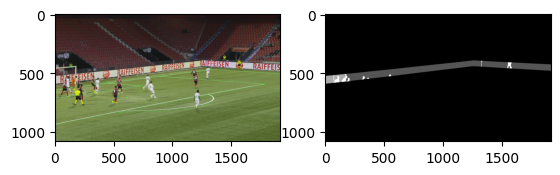

In [31]:
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 225

img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
cam.from_json_parameters(smoothedCamParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
imgWithLines = deepcopy(img)
imgWithLines = cam.draw_pitch(cam.draw_corners(imgWithLines))
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imgWithLines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

In [32]:
heights = heights[:heightsArrayLen]
np.mean(heights), np.std(heights)

(0.9767787606475176, 0.03022186854567551)

In [33]:
height = np.mean(heights)

In [34]:
for side in sides:
	# bannersDims[side]['distArray'] = bannersDims[side]['distArray'][:bannersDims[side]['distArrayLen']]
	# bannersDims[side]['dist'] = np.mean(bannersDims[side]['distArray'])
	bannersDims[side]['dist'] = np.nanmean(bannersDims[side]['distArray'])
	print(side, bannersDims[side]['dist'], np.nanstd(bannersDims[side]['distArray']))

left -57.21224785917566 0.3696113087530513
middle -38.554936366617284 0.8411160907054595
right 57.18517424800275 0.3575133346981511


In [35]:
# given 2 points, how to compute the parameters m and p of the line fct y = mx + p passing through these 2 points
def line_through_points(p1, p2):
	# p1 = (x1, y1) and p2 = (x2, y2)
	x1, y1 = p1
	x2, y2 = p2
	m = (y2 - y1) / (x2 - x1)
	p = y1 - m*x1
	return m, p

[[-3420.408024     996.11853112]
 [ 1119.99421672   457.97790057]]


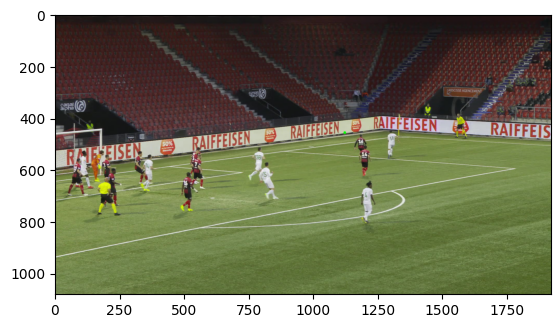

In [36]:
pts3D = np.array([[bannersDims['left']['dist'], 68/2, 0], [bannersDims['left']['dist'], -68/2, 0]])
projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
print(projectedPts)
imgWithProjectedPts = deepcopy(img)
for p in projectedPts:
	cv2.circle(imgWithProjectedPts, tuple(p.astype(int)), 5, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(imgWithProjectedPts, cv2.COLOR_BGR2RGB))

(-0.11852267751187283, 590.7226139357322)
1272
439.96176814062994


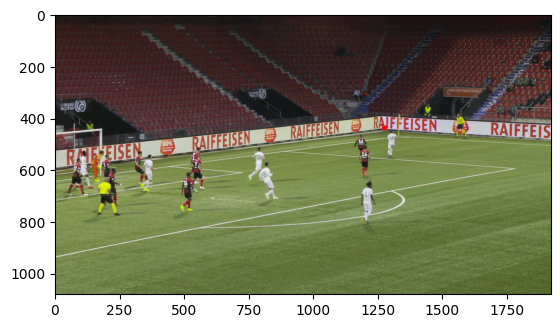

In [37]:
line1 = line_through_points(projectedPts[0], projectedPts[1])
print(line1)
side = 'left'
modelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], cornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
print(modelCornerCol)
m, p = line1
print(m*modelCornerCol + p)
imgWithIntersection = deepcopy(img)
intersectionPoint = np.array([modelCornerCol, m*modelCornerCol + p])
cv2.circle(imgWithIntersection, tuple(intersectionPoint.astype(int)), 10, (0, 0, 255), -1)
plt.imshow(cv2.cvtColor(imgWithIntersection, cv2.COLOR_BGR2RGB))

[[ 1443.36295892   454.7680491 ]
 [14026.24331847  1199.51068341]]
[[ 1443.36295892   405.17514589]
 [14026.24331847  1066.24322043]]
[[1266, 444.27047196074165], [1266, 395.8570099482131], [15637, 1150.8677092208961], [15637, 1294.8465000063868]]


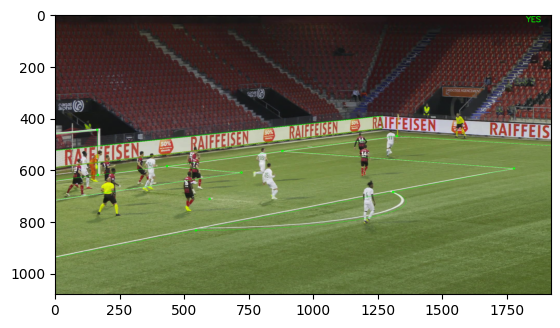

In [48]:
cv2.namedWindow('image')
cv2.moveWindow('image', 30, 40)

imgWithBanners = deepcopy(img)
for side in sides:
	if side == 'middle':
		pts3D = np.array([[-105/2, bannersDims[side]['dist'], 0], [105/2, bannersDims[side]['dist'], 0]])
		projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
		print(projectedPts)
		bottomLine = line_through_points(projectedPts[0], projectedPts[1])
		pts3D[:, 2] = -height
		projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
		print(projectedPts)
		topLine = line_through_points(projectedPts[0], projectedPts[1])
		leftModelCornerCol = cam.project_point(np.array([cornersCoords['left']['x'], cornersCoords['left']['y'], 0]), distort=False)[0].round().astype(int)
		rightModelCornerCol = cam.project_point(np.array([cornersCoords['right']['x'], cornersCoords['right']['y'], 0]), distort=False)[0].round().astype(int)
		if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
			continue
		bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
		print(bannerPts)
		# cv2.polylines(imgWithBanners, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
	else:
		if side == 'right':
			continue
		pts3D = np.array([[bannersDims[side]['dist'], 68/2, 0], [bannersDims[side]['dist'], -68/2, 0]])
		projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
		bottomLine = line_through_points(projectedPts[0], projectedPts[1])
		pts3D[:, 2] = -height
		projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
		topLine = line_through_points(projectedPts[0], projectedPts[1])
		leftModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], -cornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
		rightModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], cornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
		if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
			continue
		bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
		# print(bannerPts)
		cv2.polylines(imgWithBanners, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)

cam.draw_pitch(imgWithBanners)
cam.draw_corners(imgWithBanners)
plt.imshow(cv2.cvtColor(imgWithBanners, cv2.COLOR_BGR2RGB))
cv2.imshow('image', imgWithBanners)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
# cv2.namedWindow('image')
# cv2.moveWindow('image', 30, 40)

# # for imgNum in range(750):
# for imgNum in range(225,226):
# 	img = cv2.imread(imgPath + str(imgNum+1).zfill(6) + '.jpg')
# 	mask = cv2.imread(maskPath + str(imgNum+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# 	cam.from_json_parameters(smoothedCamParams[imgNum])
# 	binMask = np.uint8(mask > 0)
# 	contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 	largest_contour = max(contours, key=cv2.contourArea)
# 	biggestBloBMask = np.zeros(mask.shape, np.uint8)
# 	cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
# 	mask = biggestBloBMask
# 	binMask = np.uint8(mask > 0)
# 	firstNonZeroIdx = np.argmax(binMask, axis=0)
# 	colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
# 	flipped = cv2.flip(binMask, 0)
# 	flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
# 	colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
# 	firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
# 	flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
# 	lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
# 	cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
# 	cornerCol = cornerCols.mean().round().astype(int)
# 	point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
# 	cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
# 	realCornersCoords = deepcopy(cornersCoords)
# 	if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
# 		# write in the top right corner of the image "YES"
# 		cv2.putText(img, "YES", (img.shape[1] - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
# 		if cornerCoordX < 0:
# 			realCornersCoords['left']['x'] = cornerCoordX
# 			realCornersCoords['left']['y'] = cornerCoordY
# 		else:
# 			realCornersCoords['right']['x'] = cornerCoordX
# 			realCornersCoords['right']['y'] = cornerCoordY
# 	else:
# 		# write in the top right corner of the image "NO"
# 		cv2.putText(img, "NO", (img.shape[1] - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# 	for side in sides:
# 		if side == 'middle':
# 			pts3D = np.array([[-105/2, bannersDims[side]['dist'], 0], [105/2, bannersDims[side]['dist'], 0]])
# 			projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			# print(projectedPts)
# 			bottomLine = line_through_points(projectedPts[0], projectedPts[1])
# 			pts3D[:, 2] = -height
# 			projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			# print(projectedPts)
# 			topLine = line_through_points(projectedPts[0], projectedPts[1])
# 			leftModelCornerCol = cam.project_point(np.array([cornersCoords['left']['x'], cornersCoords['left']['y'], 0]), distort=False)[0].round().astype(int)
# 			rightModelCornerCol = cam.project_point(np.array([cornersCoords['right']['x'], cornersCoords['right']['y'], 0]), distort=False)[0].round().astype(int)
# 			if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
# 				continue
# 			bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
# 			# print(bannerPts)
# 			# cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=1)

# 			##############################################
# 			### Current Image banner dimensions
# 			##############################################
   
# 			bannerDim = bannersDims[side]['distArray'][imgNum]
# 			if np.isnan(bannerDim):
# 				bannerDim = bannersDims[side]['dist']
# 			pts3D = np.array([[-105/2, bannerDim, 0], [105/2, bannerDim, 0]])
# 			projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			# print(projectedPts)
# 			bottomLine = line_through_points(projectedPts[0], projectedPts[1])
# 			pts3D[:, 2] = -height
# 			projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			# print(projectedPts)
# 			topLine = line_through_points(projectedPts[0], projectedPts[1])
# 			leftModelCornerCol = cam.project_point(np.array([realCornersCoords['left']['x'], realCornersCoords['left']['y'], 0]), distort=False)[0].round().astype(int)
# 			rightModelCornerCol = cam.project_point(np.array([realCornersCoords['right']['x'], realCornersCoords['right']['y'], 0]), distort=False)[0].round().astype(int)
# 			if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
# 				continue
# 			bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
# 			# print(bannerPts)
# 			cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
# 		else:
# 			pts3D = np.array([[bannersDims[side]['dist'], 68/2, 0], [bannersDims[side]['dist'], -68/2, 0]])
# 			projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			bottomLine = line_through_points(projectedPts[0], projectedPts[1])
# 			pts3D[:, 2] = -height
# 			projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			topLine = line_through_points(projectedPts[0], projectedPts[1])
# 			leftModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], -cornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
# 			rightModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], cornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
# 			if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
# 				continue
# 			bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
# 			# print(bannerPts)
# 			# cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=1)

# 			##############################################
# 			### Current Image banner dimensions
# 			##############################################

# 			bannerDim = bannersDims[side]['distArray'][imgNum]
# 			if np.isnan(bannerDim):
# 				bannerDim = bannersDims[side]['dist']
# 			pts3D = np.array([[bannerDim, 68/2, 0], [bannerDim, -68/2, 0]])
# 			projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			bottomLine = line_through_points(projectedPts[0], projectedPts[1])
# 			pts3D[:, 2] = -height
# 			projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
# 			if np.any(projectedPts == 0):  #projected points are not in the image
# 				continue
# 			topLine = line_through_points(projectedPts[0], projectedPts[1])
# 			leftModelCornerCol = cam.project_point(np.array([realCornersCoords[side]['x'], -realCornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
# 			rightModelCornerCol = cam.project_point(np.array([realCornersCoords[side]['x'], realCornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
# 			if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
# 				continue
# 			bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
# 			# print(bannerPts)
# 			cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)

# 	# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# 	cv2.imshow('image', img)
# 	cv2.waitKey(1)


# cv2.destroyAllWindows()

In [49]:
# Credits: https://github.com/SoccerNet/sn-gamestate/blob/main/plugins/calibration/sn_calibration_baseline/camera.py

def rotation_matrix_to_pan_tilt_roll(rotation):
    """
    Decomposes the rotation matrix into pan, tilt and roll angles. There are two solutions, but as we know that cameramen
    try to minimize roll, we take the solution with the smallest roll.
    :param rotation: rotation matrix
    :return: pan, tilt and roll in radians
    """
    orientation = np.transpose(rotation)
    first_tilt = np.arccos(orientation[2, 2])
    second_tilt = - first_tilt

    sign_first_tilt = 1. if np.sin(first_tilt) > 0. else -1.
    sign_second_tilt = 1. if np.sin(second_tilt) > 0. else -1.

    first_pan = np.arctan2(sign_first_tilt * orientation[0, 2], sign_first_tilt * - orientation[1, 2])
    second_pan = np.arctan2(sign_second_tilt * orientation[0, 2], sign_second_tilt * - orientation[1, 2])
    first_roll = np.arctan2(sign_first_tilt * orientation[2, 0], sign_first_tilt * orientation[2, 1])
    second_roll = np.arctan2(sign_second_tilt * orientation[2, 0], sign_second_tilt * orientation[2, 1])

    # print(f"first solution {first_pan*180./np.pi}, {first_tilt*180./np.pi}, {first_roll*180./np.pi}")
    # print(f"second solution {second_pan*180./np.pi}, {second_tilt*180./np.pi}, {second_roll*180./np.pi}")
    if np.fabs(first_roll) < np.fabs(second_roll):
        return first_pan, first_tilt, first_roll
    return second_pan, second_tilt, second_roll

def pan_tilt_roll_to_orientation(pan, tilt, roll):
    """
    Conversion from euler angles to orientation matrix.
    :param pan:
    :param tilt:
    :param roll:
    :return: orientation matrix
    """
    Rpan = np.array([
        [np.cos(pan), -np.sin(pan), 0],
        [np.sin(pan), np.cos(pan), 0],
        [0, 0, 1]])
    Rroll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]])
    Rtilt = np.array([
        [1, 0, 0],
        [0, np.cos(tilt), -np.sin(tilt)],
        [0, np.sin(tilt), np.cos(tilt)]])
    rotMat = np.dot(Rpan, np.dot(Rtilt, Rroll))
    return rotMat

In [50]:
cv2.namedWindow('image')
cv2.moveWindow('image', 30, 40)

# for imgNum in range(750):
for imgNum in range(225,230):
	for correction in range(1):
		print('correction:', correction)

		img = cv2.imread(imgPath + str(imgNum+1).zfill(6) + '.jpg')
		mask = cv2.imread(maskPath + str(imgNum+1).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
		if not correction:
			cam.from_json_parameters(smoothedCamParams[imgNum])
		binMask = np.uint8(mask > 0)
		contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
		largest_contour = max(contours, key=cv2.contourArea)
		biggestBloBMask = np.zeros(mask.shape, np.uint8)
		cv2.drawContours(biggestBloBMask, [largest_contour], 0, 255, cv2.FILLED)
		mask = biggestBloBMask
		binMask = np.uint8(mask > 0)
		firstNonZeroIdx = np.argmax(binMask, axis=0)
		colsWithNonZero = np.where(firstNonZeroIdx != 0)[0]
		flipped = cv2.flip(binMask, 0)
		flippedLastNonZeroIdx = np.argmax(flipped, axis=0)
		colsWithNonZero = np.union1d(colsWithNonZero, np.where(flippedLastNonZeroIdx != 0)[0])
		firstNonZeroIdx = firstNonZeroIdx[colsWithNonZero]
		flippedLastNonZeroIdx = flippedLastNonZeroIdx[colsWithNonZero]
		lastNonZeroIdx = mask.shape[0] - flippedLastNonZeroIdx - 1
		cornerCols = colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)]
		cornerCol = cornerCols.mean().round().astype(int)
		point2D = np.array([colsWithNonZero[firstNonZeroIdx == np.min(firstNonZeroIdx)].mean(), lastNonZeroIdx[np.where(firstNonZeroIdx == np.min(firstNonZeroIdx))[0].mean().round().astype(int)]])
		cornerCoordX, cornerCoordY = cam.unproject_point_on_planeZ0(point2D)[:2]
		realCornersCoords = deepcopy(cornersCoords)
		if cornerCoordY < -68/2 and (cornerCoordX < -105/2 or cornerCoordX > 105/2) and not (0 in cornerCols or mask.shape[1] - 1 in cornerCols):
			# write in the top right corner of the image "YES"
			cv2.putText(img, "YES", (img.shape[1] - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
			if cornerCoordX < 0:
				realCornersCoords['left']['x'] = cornerCoordX
				realCornersCoords['left']['y'] = cornerCoordY
			else:
				realCornersCoords['right']['x'] = cornerCoordX
				realCornersCoords['right']['y'] = cornerCoordY
		else:
			# write in the top right corner of the image "NO"
			cv2.putText(img, "NO", (img.shape[1] - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

		objectPoints = []
		imagePoints = []

		for side in sides:
			if side == 'middle':
				continue
				pts3D = np.array([[-105/2, bannersDims[side]['dist'], 0], [105/2, bannersDims[side]['dist'], 0]])
				projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				# print(projectedPts)
				bottomLine = line_through_points(projectedPts[0], projectedPts[1])
				pts3D[:, 2] = -height
				projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				# print(projectedPts)
				topLine = line_through_points(projectedPts[0], projectedPts[1])
				leftModelCornerCol = cam.project_point(np.array([cornersCoords['left']['x'], cornersCoords['left']['y'], 0]), distort=False)[0].round().astype(int)
				rightModelCornerCol = cam.project_point(np.array([cornersCoords['right']['x'], cornersCoords['right']['y'], 0]), distort=False)[0].round().astype(int)
				if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
					continue
				bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
				# print(bannerPts)
				cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=1)

				##############################################
				### Current Image banner dimensions
				##############################################
	
				bannerDim = bannersDims[side]['distArray'][imgNum]
				if np.isnan(bannerDim):
					bannerDim = bannersDims[side]['dist']
				pts3D = np.array([[-105/2, bannerDim, 0], [105/2, bannerDim, 0]])
				projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				# print(projectedPts)
				bottomLine = line_through_points(projectedPts[0], projectedPts[1])
				pts3D[:, 2] = -height
				projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				# print(projectedPts)
				topLine = line_through_points(projectedPts[0], projectedPts[1])
				leftModelCornerCol = cam.project_point(np.array([realCornersCoords['left']['x'], realCornersCoords['left']['y'], 0]), distort=False)[0].round().astype(int)
				rightModelCornerCol = cam.project_point(np.array([realCornersCoords['right']['x'], realCornersCoords['right']['y'], 0]), distort=False)[0].round().astype(int)
				if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
					continue
				bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
				# print(bannerPts)
				cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)
			else:
				if side == 'right':
					continue
				pts3D = np.array([[bannersDims[side]['dist'], 68/2, 0], [bannersDims[side]['dist'], -68/2, 0]])
				# objectPoints.append(deepcopy(pts3D))
				projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
				# imagePoints.append(deepcopy(projectedPts))
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				bottomLine = line_through_points(projectedPts[0], projectedPts[1])
				pts3D[:, 2] = -height
				# objectPoints.append(deepcopy(pts3D[::-1]))
				projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
				# imagePoints.append(deepcopy(projectedPts[::-1]))
				if np.any(projectedPts == 0):  #projected points are not in the image
					continue
				topLine = line_through_points(projectedPts[0], projectedPts[1])
				leftModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], -cornersCoords[side]['y'], 0]), distort=False)[0]
				rightModelCornerCol = cam.project_point(np.array([cornersCoords[side]['x'], cornersCoords[side]['y'], 0]), distort=False)[0]
				if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
					continue
				bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
				# bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]]]
				imagePoints.append(deepcopy(bannerPts))
				print('unprojected bottom banner point')
				print([cam.unproject_point_on_planeZ0(np.array(p), undistort=False) for p in [bannerPts[0], bannerPts[3]]])
				bannerPts = np.array(bannerPts).round().astype(np.int32)
				# print(bannerPts)
				cv2.polylines(img, [bannerPts], isClosed=True, color=(0, 0, 255), thickness=1)

				# ##############################################
				# ### Current Image banner dimensions
				# ##############################################

				# bannerDim = bannersDims[side]['distArray'][imgNum]
				# if np.isnan(bannerDim):
				# 	bannerDim = bannersDims[side]['dist']
				# pts3D = np.array([[bannerDim, 68/2, 0], [bannerDim, -68/2, 0]])
				# projectedPts = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])
				# # imagePoints.append(deepcopy(projectedPts))
				# if np.any(projectedPts == 0):  #projected points are not in the image
				# 	continue
				# bottomLine = line_through_points(projectedPts[0], projectedPts[1])
				# pts3D[:, 2] = -height
				# projectedPts[:,1] = np.array([cam.project_point(p, distort=False)[:2] for p in pts3D])[:, 1]
				# # imagePoints.append(deepcopy(projectedPts[::-1]))
				# if np.any(projectedPts == 0):  #projected points are not in the image
				# 	continue
				# topLine = line_through_points(projectedPts[0], projectedPts[1])
				# leftModelCornerCol = cam.project_point(np.array([realCornersCoords[side]['x'], -realCornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
				# rightModelCornerCol = cam.project_point(np.array([realCornersCoords[side]['x'], realCornersCoords[side]['y'], 0]), distort=False)[0].round().astype(int)
				# if leftModelCornerCol == 0 or rightModelCornerCol == 0:  # corners are not in the image
				# 	continue
				# bannerPts = [[leftModelCornerCol, bottomLine[0]*leftModelCornerCol + bottomLine[1]], [leftModelCornerCol, topLine[0]*leftModelCornerCol + topLine[1]], [rightModelCornerCol, topLine[0]*rightModelCornerCol + topLine[1]], [rightModelCornerCol, bottomLine[0]*rightModelCornerCol + bottomLine[1]]]
				# # print(bannerPts)
				# cv2.polylines(img, [np.array(bannerPts).astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)

		# if not correction:
		# 	print('objectPoints:', objectPoints)
		# 	print('imagePoints:', imagePoints)
		# 	cameraMatrix = np.array(cam.calibration, dtype=np.float64)
		# 	objectPoints = np.ascontiguousarray(objectPoints, dtype=np.float64).reshape(-1, 3)
		# 	# imagePoints = np.ascontiguousarray(imagePoints, dtype=np.float64).reshape(-1, 2)
		# 	# imagePoints as shape (1, 4, 2) make it (4, 2)
		# 	imagePoints = np.ascontiguousarray(imagePoints, dtype=np.float64).reshape(4, 2)
		# 	print(objectPoints.shape, imagePoints.shape, cameraMatrix.shape, sep='\n')
		# 	print(objectPoints, imagePoints, [cam.project_point(p, distort=False)[:2] for p in objectPoints], sep='\n')
		# 	ret, rvec, tvec = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, None, flags=cv2.SOLVEPNP_P3P)
		# 	rotation, _ = cv2.Rodrigues(rvec)
		# 	position = - np.transpose(rotation) @ tvec.flatten()
		# 	pan, tilt, roll = rotation_matrix_to_pan_tilt_roll(rotation)
		# 	if -np.pi/2 > pan or pan > np.pi/2:
		# 		dpi = -np.sign(pan) * np.pi
		# 		pan += dpi
		# 		roll *=-1
		# 		position[2] *= -1
		# 	print(cam.to_json_parameters())
		# 	rotation = np.transpose(pan_tilt_roll_to_orientation(pan, tilt, roll))
		# 	print(np.array(rotation_matrix_to_pan_tilt_roll(rotation)) * 180 / np.pi)
		# 	print('position:', position, sep='\n')
		# 	cam.position = position
		# 	cam.rotation = rotation
		# else:
		# 	print(cam.to_json_parameters())
		


		# # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		# cv2.imshow('image', img)
		# cv2.waitKey(0)

cv2.destroyAllWindows()

correction: 0
unprojected bottom banner point
[array([-57.21224786,  38.98744108,  -0.        ]), array([-57.21224786, -39.46930386,  -0.        ])]
correction: 0
unprojected bottom banner point
[array([-57.21224786,  38.98709042,  -0.        ]), array([-57.21224786, -39.46898427,  -0.        ])]
correction: 0
unprojected bottom banner point
[array([-57.21224786,  38.98521224,  -0.        ]), array([-57.21224786, -39.46818539,  -0.        ])]
correction: 0
unprojected bottom banner point
[array([-57.21224786,  38.98378717,  -0.        ]), array([-57.21224786, -39.46783171,  -0.        ])]
correction: 0
unprojected bottom banner point
[array([-57.21224786,  38.9836895 ,  -0.        ]), array([-57.21224786, -39.46780658,  -0.        ])]


In [42]:
pts1 = np.array([[0, 0], [0.5, 1], [1.5, 1], [1, 0]]).astype(np.float32)
pts2 = deepcopy(pts1) + 16.96
H1 = cv2.getPerspectiveTransform(pts1, pts2)
print(H1)
print(pts1)
print(pts2)
print(cv2.perspectiveTransform(np.array([pts1]), H1))
pts3  = deepcopy(pts2) + 25.44
H2 = cv2.getPerspectiveTransform(pts2, pts3)
print(H2)
print(pts2)
print(pts3)
print(cv2.perspectiveTransform(np.array([pts2]), H2))
# from pts1 to pts3
H3 = H2 @ H1
print(H3)
print(pts1)
print(pts3)
print(cv2.perspectiveTransform(np.array([pts1]), H3))

[[ 1.          0.         16.95999908]
 [ 0.          1.         16.95999908]
 [ 0.          0.          1.        ]]
[[0.  0. ]
 [0.5 1. ]
 [1.5 1. ]
 [1.  0. ]]
[[16.96 16.96]
 [17.46 17.96]
 [18.46 17.96]
 [17.96 16.96]]
[[[16.96 16.96]
  [17.46 17.96]
  [18.46 17.96]
  [17.96 16.96]]]
[[ 1.00000000e+00 -1.59026144e-13  2.54400024e+01]
 [ 1.60270766e-13  1.00000000e+00  2.54400024e+01]
 [ 3.77452790e-15 -3.55248330e-15  1.00000000e+00]]
[[16.96 16.96]
 [17.46 17.96]
 [18.46 17.96]
 [17.96 16.96]]
[[42.4 42.4]
 [42.9 43.4]
 [43.9 43.4]
 [43.4 42.4]]
[[[42.4 42.4]
  [42.9 43.4]
  [43.9 43.4]
  [43.4 42.4]]]
[[ 1.00000000e+00 -1.59026144e-13  4.24000015e+01]
 [ 1.60270766e-13  1.00000000e+00  4.24000015e+01]
 [ 3.77452790e-15 -3.55248330e-15  1.00000000e+00]]
[[0.  0. ]
 [0.5 1. ]
 [1.5 1. ]
 [1.  0. ]]
[[42.4 42.4]
 [42.9 43.4]
 [43.9 43.4]
 [43.4 42.4]]
[[[42.4 42.4]
  [42.9 43.4]
  [43.9 43.4]
  [43.4 42.4]]]
